# Clustering

In this notebook, we learn about one of the most common un-supervised learning methods: clustering. There isn't a single algorithm for clustering, but the most common one is called **k-means clustering** where $k$ refers to the number of clusters we wish to have. Note that $k$ isn't really something we can learn from the data. It's something we must specify ahead of time, and while there are some guidelines we can use to choose a reasonable value for $k$ (see the assignment), ultimately it's somewhat of a subjective choice. In fact, with un-supervised learning in general, there is a lot of subjectivity involved, making it hard to interpret results.

We have featurized the `retail-churn.csv` data using RFM. In this assignment, we build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [1]:
import pandas as pd
import numpy as np

col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


1. Rerun the feature engineering steps on the data to extract RFM features (cuz why not :) )

In [2]:
churn['timestamp'] = pd.to_datetime(churn['timestamp'])
churn['date'] = churn['timestamp'].dt.date
churn_agg = churn.groupby(['user_id','date']).agg({'quantity':'sum','dollar':'sum'})
churn_agg = churn_agg.reset_index()
churn_agg['date'] = pd.to_datetime(churn_agg['date'])
last_visit_ndays = churn_agg.groupby('user_id')['date'].diff()
quantity_roll_sum_7D = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
quantity_roll_sum_7D = quantity_roll_sum_7D.reset_index()
dollar_roll_sum_7D = churn_agg.groupby('user_id', as_index = False).rolling(window = '7D', on = 'date')['dollar'].sum()
dollar_roll_sum_7D = dollar_roll_sum_7D.reset_index()
churn_roll = churn_agg
churn_roll['last_visit_ndays']=last_visit_ndays
churn_roll['quantity_roll_sum_7D'] = quantity_roll_sum_7D['quantity']
churn_roll['dollar_roll_sum_7D']=dollar_roll_sum_7D['dollar']
churn_roll = churn_roll.fillna(pd.Timedelta('100 days'))
churn_roll.head()


,user_id,date,quantity,dollar,last_visit_ndays,quantity_roll_sum_7D,dollar_roll_sum_7D
0,1113,2000-11-12,5,420,100 days,5.0,420.0
1,1113,2000-11-26,3,558,14 days,3.0,558.0
2,1113,2000-11-27,6,624,1 days,9.0,1182.0
3,1113,2001-01-06,9,628,40 days,9.0,628.0
4,1250,2001-02-04,5,734,100 days,5.0,734.0


In [3]:
#convert last_visit_ndays into float types
churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays']/pd.Timedelta(days=1)
churn_roll.dtypes

user_id                          int64
date                    datetime64[ns]
quantity                         int64
dollar                           int64
last_visit_ndays               float64
quantity_roll_sum_7D           float64
dollar_roll_sum_7D             float64
dtype: object

2. Train a k-means algorithm on the RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the standardized scale. 

In [4]:
from sklearn.cluster import KMeans
n_clusters = 10 # the number of clusters (k)
which_cols = ['last_visit_ndays', 'quantity_roll_sum_7D', 'dollar_roll_sum_7D' ]

X = churn_roll[which_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_roll['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
print(kmeans.cluster_centers_)
churn_roll.head()

[[4.18867378e+01 5.44447599e+00 3.28507608e+02]
 [3.41363259e+01 2.94031588e+01 3.37587157e+03]
 [1.04000000e+01 1.86040000e+02 2.70981600e+04]
 [1.38750000e+01 1.59500000e+02 6.45926250e+04]
 [3.53012138e+01 2.07103641e+01 2.00820971e+03]
 [2.82339667e+01 4.08693587e+01 5.54088480e+03]
 [7.77272727e+00 2.58000000e+02 3.79649545e+04]
 [3.73311005e+01 1.29209569e+01 1.03721876e+03]
 [1.10923077e+01 1.49061538e+02 1.63272462e+04]
 [2.39261993e+01 6.04649446e+01 9.09821402e+03]]


,user_id,date,quantity,dollar,last_visit_ndays,quantity_roll_sum_7D,dollar_roll_sum_7D,cluster
0,1113,2000-11-12,5,420,100.0,5.0,420.0,0
1,1113,2000-11-26,3,558,14.0,3.0,558.0,0
2,1113,2000-11-27,6,624,1.0,9.0,1182.0,7
3,1113,2001-01-06,9,628,40.0,9.0,628.0,0
4,1250,2001-02-04,5,734,100.0,5.0,734.0,7


3. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 3 to 15. 

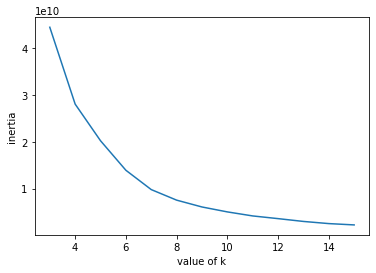

In [5]:
import matplotlib.pyplot as plt 
which_cols = ['last_visit_ndays', 'quantity_roll_sum_7D', 'dollar_roll_sum_7D' ]
X = churn_roll[which_cols]
dist = [ 0 for x in range(3,16)]
k = np.arange(3,16,1)
for i in range(3,16):
    n_clusters = i # the number of clusters k
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
    kmeans.fit(X) # step 2, learn the clusters
    churn_roll['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
    dist[i-3] = kmeans.inertia_
plt.plot(k, dist) 
plt.xlabel("value of k")
plt.ylabel("inertia")
plt.show()

4. Based on the plot, k = 7 is a good value to pick for k because the optimal k value is at the elbow of the scree plot

5. Train a k-means algorithm on the RFM features using your new value of $k$. Report the  size, mean and standard deviation for the RFM features for each cluster.

In [6]:
n_clusters = 7 # the number of clusters (k)
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_roll['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
size_cluster = churn_roll.groupby('cluster').size()
mean_cluster = churn_roll.groupby('cluster').mean()
std_cluster = churn_roll.groupby('cluster').std()
print("size for each cluster is: \n",size_cluster)
print("mean of RFM feature for each cluster are: \n", mean_cluster)
print("standard deviation for the RFM features: \n",std_cluster)
churn_roll.head()

size for each cluster is: 
 cluster
0    10226
1       42
2      882
3    21971
4        9
5      127
6     3801
dtype: int64
mean of RFM feature for each cluster are: 
               user_id   quantity        dollar  last_visit_ndays  \
cluster                                                            
0        1.395666e+06  12.159984   1123.564541         36.349990   
1        1.542695e+06  61.238095  12459.476190          7.309524   
2        1.340559e+06  26.803855   3899.900227         27.168934   
3        1.406635e+06   5.406445    360.649811         41.034181   
4        1.771734e+06  73.777778  29490.555556         12.555556   
5        1.283434e+06  47.149606   7236.818898         15.370079   
6        1.381711e+06  19.331492   2224.537490         34.459616   

         quantity_roll_sum_7D  dollar_roll_sum_7D  
cluster                                            
0                   16.540485         1468.697927  
1                  230.761905        32697.595238  
2        

,user_id,date,quantity,dollar,last_visit_ndays,quantity_roll_sum_7D,dollar_roll_sum_7D,cluster
0,1113,2000-11-12,5,420,100.0,5.0,420.0,3
1,1113,2000-11-26,3,558,14.0,3.0,558.0,3
2,1113,2000-11-27,6,624,1.0,9.0,1182.0,0
3,1113,2001-01-06,9,628,40.0,9.0,628.0,3
4,1250,2001-02-04,5,734,100.0,5.0,734.0,3


6. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features).
we'll take a look at a 2 way table for cluster 4,0,3 as small, medium, and large size cluster

In [12]:
two_way = pd.crosstab(churn_roll['cluster'], churn_roll['last_visit_ndays'], normalize = True)
two_way

last_visit_ndays,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,118.0
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.029224,0.022181,0.017243,0.014464,0.011118,0.011981,0.006746,0.004614,0.003886,0.003778,...,0.000027,0.000027,0.000054,0.000000,0.000000,0.000000,0.000054,0.000027,0.000000,0.000027
1,0.000594,0.000135,0.000108,0.000054,0.000027,0.000000,0.000000,0.000000,0.000027,0.000027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.005559,0.003184,0.001673,0.001457,0.001214,0.000810,0.000135,0.000324,0.000135,0.000162,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.028739,0.023342,0.020886,0.019483,0.016515,0.015435,0.025689,0.019456,0.015435,0.013654,...,0.000054,0.000108,0.000027,0.000054,0.000054,0.000027,0.000000,0.000027,0.000027,0.000000
4,0.000108,0.000081,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.001295,0.000513,0.000216,0.000216,0.000243,0.000027,0.000027,0.000027,0.000027,0.000054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.014788,0.009553,0.007043,0.006045,0.004614,0.004372,0.001889,0.001241,0.001160,0.000810,...,0.000027,0.000027,0.000054,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
